## 1. Import Library


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## 2. Load Dataset


In [2]:
df = pd.read_csv('/content/spend_analysis_dataset.csv')

## 3. Data Understanding

### Menampilkan 5 data teratas

In [3]:
print(df.head())

  TransactionID                 ItemName         Category  Quantity  \
0        TXN001               Desk Chair        Furniture        10   
1        TXN002                  Stapler  Office Supplies        16   
2        TXN003  Annual Software License         Software         1   
3        TXN004                  Notepad       Stationery        13   
4        TXN005                  Notepad       Stationery        19   

   UnitPrice  TotalCost PurchaseDate         Supplier            Buyer  
0     113.15    1131.50   2024-04-19    TechMart Inc.     Kelly Joseph  
1      12.62     201.92   2024-07-06  CloudSoft Corp.     Kelly Joseph  
2    5649.34    5649.34   2024-09-10    TechMart Inc.     Kelly Joseph  
3       2.92      37.96   2024-01-21  FurniWorks Ltd.     Luis Holland  
4       1.39      26.41   2024-02-03    TechMart Inc.  Cynthia Jenkins  


### Cek informasi dataset


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  500 non-null    object 
 1   ItemName       500 non-null    object 
 2   Category       500 non-null    object 
 3   Quantity       500 non-null    int64  
 4   UnitPrice      500 non-null    float64
 5   TotalCost      500 non-null    float64
 6   PurchaseDate   500 non-null    object 
 7   Supplier       500 non-null    object 
 8   Buyer          500 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 35.3+ KB
None


### Cek missing values


In [5]:
print(df.isnull().sum())

TransactionID    0
ItemName         0
Category         0
Quantity         0
UnitPrice        0
TotalCost        0
PurchaseDate     0
Supplier         0
Buyer            0
dtype: int64


### Cek duplikat


In [6]:
print(df.duplicated().sum())

0


## 4. Exploratory Data Analysis (EDA)

### Statistik Deskriptif

In [7]:
df.describe()

,Quantity,UnitPrice,TotalCost
count,500.000000,500.000000,500.00000
mean,9.640000,854.245100,2481.16106
std,6.168834,2132.890832,3527.35316
min,1.000000,1.060000,1.56000
25%,4.000000,14.380000,145.92750
50%,10.000000,143.595000,918.56000
75%,15.000000,287.925000,3123.56750
max,20.000000,9909.240000,18494.60000


### Plot distribusi TotalCost


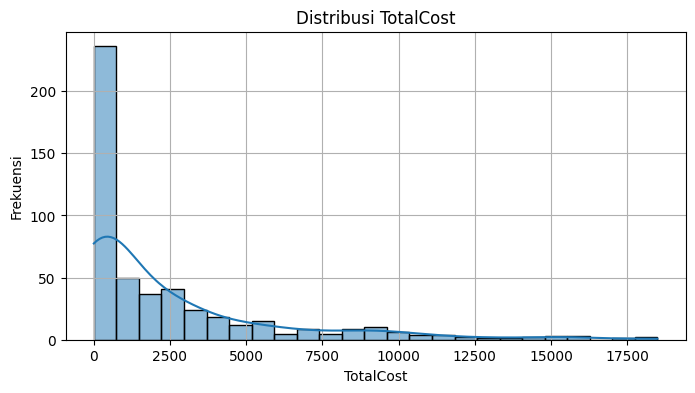

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(df['TotalCost'], kde=True)
plt.title('Distribusi TotalCost')
plt.xlabel('TotalCost')
plt.ylabel('Frekuensi')
plt.grid()
plt.show()

### Korelasi Quantity, UnitPrice, TotalCost

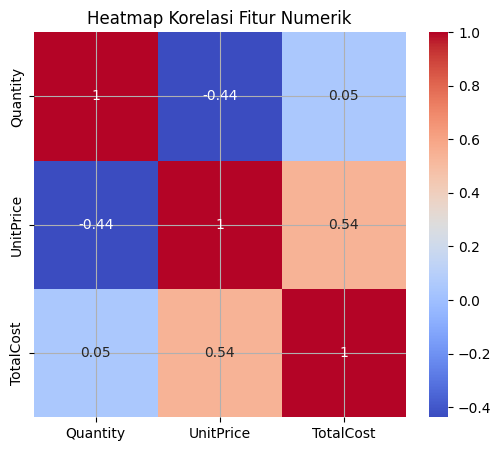

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['Quantity', 'UnitPrice', 'TotalCost']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.grid()
plt.show()

## 5. Data Preparation

In [10]:
# Pastikan PurchaseDate bertipe datetime
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

In [11]:
# Gunakan hanya kolom PurchaseDate dan TotalCost
df = df[['PurchaseDate', 'TotalCost']]

In [12]:
# Set PurchaseDate menjadi index
df.set_index('PurchaseDate', inplace=True)

In [13]:
# Resample data menjadi bulanan (monthly)
df_monthly = df.resample('M').sum()

<ipython-input-13-afb86f7afb3e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()


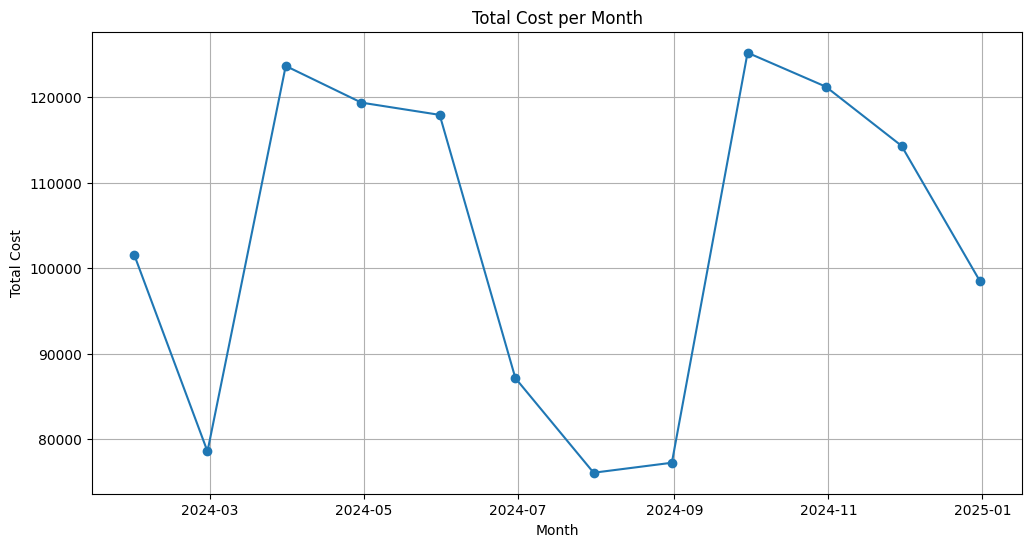

In [14]:
# Plot total cost per bulan
plt.figure(figsize=(12,6))
plt.plot(df_monthly, marker='o')
plt.title('Total Cost per Month')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.grid()
plt.show()

## 6. Membuat Windowed Dataset

In [15]:
# Scaling data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_monthly)

In [16]:
# Fungsi membuat window dataset
def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_windowed_dataset(df_scaled, window_size)

In [17]:
# Split data (80% train, 20% test)
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 7. Modeling

In [18]:
#LTSM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 8. Training

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4860 - val_loss: 0.3999
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4801 - val_loss: 0.3916
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4745 - val_loss: 0.3834
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.4689 - val_loss: 0.3753
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4635 - val_loss: 0.3674
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4582 - val_loss: 0.3595
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4530 - val_loss: 0.3517
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.4477 - val_loss: 0.3439
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.4426 - val_loss: 0.3361
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.4374 - val_loss: 0.3283
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4322 - val_loss: 0.3206
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.4271 - v

## 9. Evaluasi Model

In [20]:
# Prediksi
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


In [21]:
# Inverse transform hasil prediksi dan y_test
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), df_monthly.shape[1]-1)), y_pred), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), df_monthly.shape[1]-1)), y_test), axis=1))[:, -1]

In [22]:
# Hitung metrik evaluasi
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 7108.12
RMSE: 7935.66


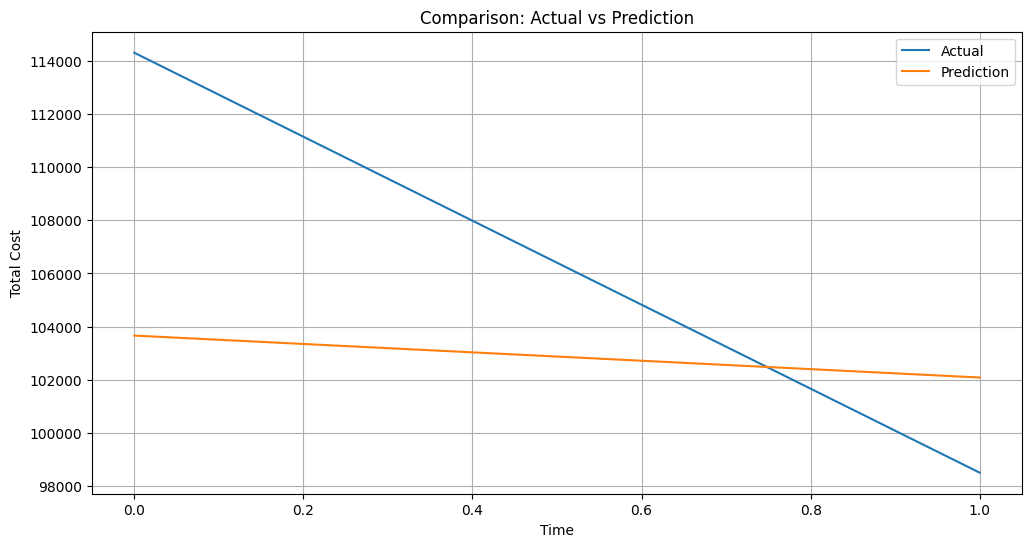

In [23]:
# Plot hasil prediksi vs aktual
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Prediction')
plt.legend()
plt.title('Comparison: Actual vs Prediction')
plt.xlabel('Time')
plt.ylabel('Total Cost')
plt.grid()
plt.show()
